Preprocessing data
Clustering data


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les


Evaluating Random Forest...
ACCURACY: 0.9714 (±0.0313)
PRECISION: 0.9729 (±0.0298)
RECALL: 0.9714 (±0.0313)
F1: 0.9715 (±0.0309)
KAPPA: 0.9523 (±0.0533)
MCC: 0.9531 (±0.0529)
AUC: 0.9960 (±0.0080)

Cluster 0 metrics:
ACCURACY: 0.9714 (±0.0313)
PRECISION: 0.9678 (±0.0263)
RECALL: 0.9800 (±0.0400)
F1: 0.9735 (±0.0281)
KAPPA: 0.9424 (±0.0634)
MCC: 0.9433 (±0.0629)

Cluster 1 metrics:
ACCURACY: 1.0000 (±0.0000)
PRECISION: 1.0000 (±0.0000)
RECALL: 1.0000 (±0.0000)
F1: 1.0000 (±0.0000)
KAPPA: 1.0000 (±0.0000)
MCC: 1.0000 (±0.0000)

Cluster 2 metrics:
ACCURACY: 0.9714 (±0.0313)
PRECISION: 0.9600 (±0.0800)
RECALL: 0.9333 (±0.0544)
F1: 0.9449 (±0.0577)
KAPPA: 0.9257 (±0.0791)
MCC: 0.9272 (±0.0783)

Evaluating Decision Tree...
ACCURACY: 0.9539 (±0.0389)
PRECISION: 0.9586 (±0.0343)
RECALL: 0.9539 (±0.0389)
F1: 0.9542 (±0.0379)
KAPPA: 0.9251 (±0.0650)
MCC: 0.9275 (±0.0634)
AUC: 0.9608 (±0.0301)

Cluster 0 metrics:
ACCURACY: 0.9539 (±0.0389)
PRECISION: 0.9673 (±0.0268)
RECALL: 0.9392 (±0.0744)
F1:

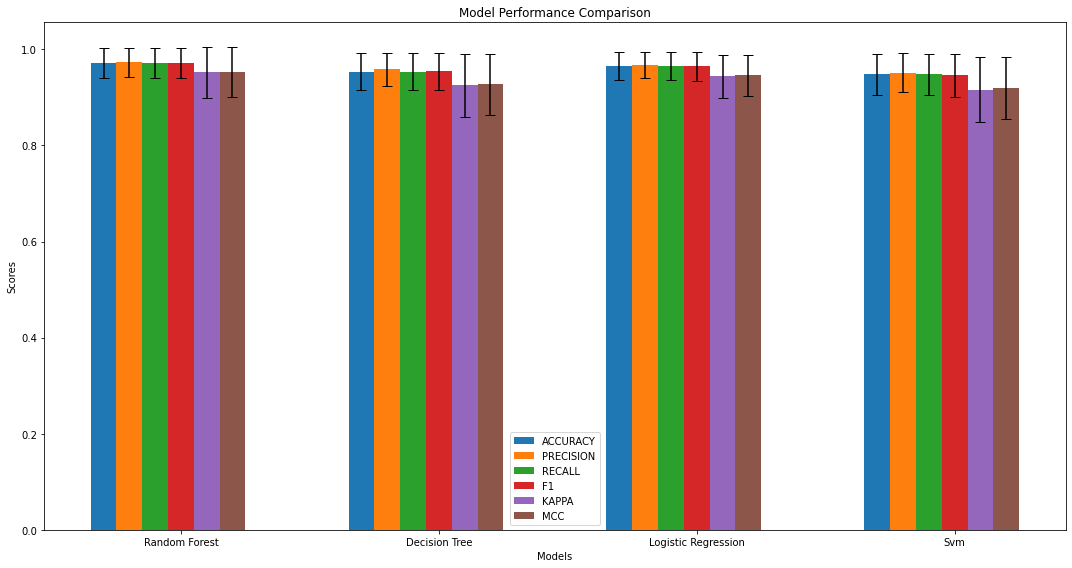

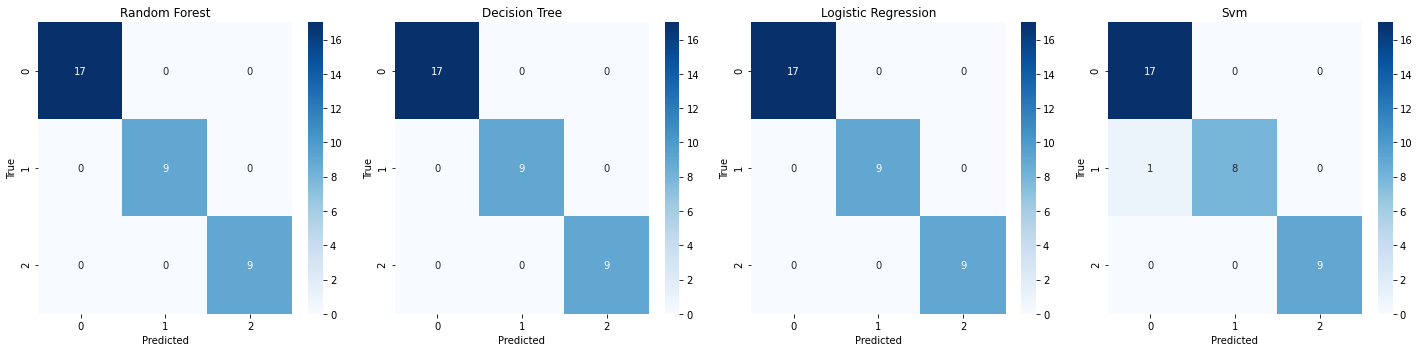

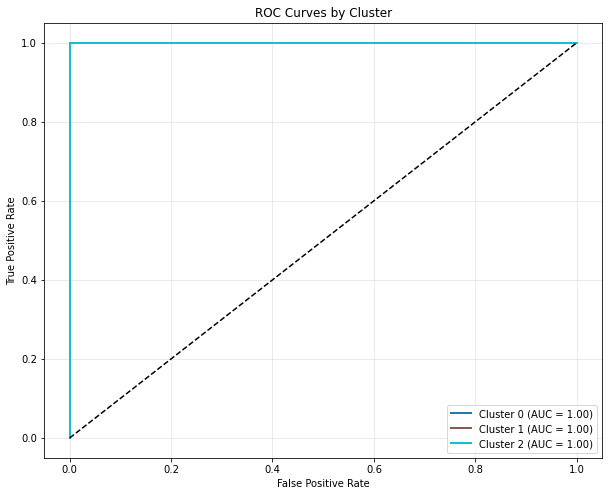

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    cohen_kappa_score, matthews_corrcoef, make_scorer, auc, roc_curve
)
from sklearn.preprocessing import label_binarize
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns

class StudentRiskPredictor:
    def __init__(self):
        self.models = {
            'random_forest': RandomForestClassifier(random_state=42),
            'decision_tree': DecisionTreeClassifier(random_state=42),
            'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
            'svm': SVC(random_state=42, probability=True)
        }
        self.best_model = None
        self.kmeans = None
        self.scaler = None
        self.optimal_clusters = None
        self.model_metrics = {}
        self.response_mapping = {
            'Strongly Agreed': 4, 'Strongly agree': 4, 'Agreed': 3, 'Agree': 3,
            'Neutral': 2, 'neutral': 2, 'Disagree': 1, 'Strongly Disagree': 0,
            'Strongly disagree': 0, 'very stable': 4, 'Stable': 3, 'Not stable': 1,
            'Not very stable': 0, 'more frequently': 4, 'Most frequently': 4,
            'frequently': 3, 'Not Frequently': 1, 'not frequently': 1, 'Not at All': 0,
            'not more frequently': 0, 'less than 2.0': 4, '2.0 to 2.49': 3,
            '2.5 to 3.49': 2, '3.5 to 4.49': 1, '4.5 and above': 0, 'Strong Support': 4,
            'Little Support': 3, 'Bad support': 1, 'No support': 0,
            'Strong sense of belonging': 4, 'Little sesnse of belonging': 3,
            'No sense of belonging': 1, 'Worst Sense of belonging': 0
        }
        pass
    
    def preprocess_data(self, data_path):
        """
        Preprocess the student data for risk analysis.

        Args:
            data_path (str): Path to the raw CSV dataset.

        Returns:
            pd.DataFrame: Preprocessed data ready for scaling and modeling.
        """
        # Load the dataset
        data = pd.read_csv(data_path)

        # Drop Timestamp column if it exists
        if 'Timestamp' in data.columns:
            data = data.drop('Timestamp', axis=1)

        # Drop initial irrelevant rows
        if data.shape[0] > 10:  # Only drop if we have enough rows
            data = data.drop(range(10))

        # Reset index after dropping rows
        data = data.reset_index(drop=True)

        # Handle age group columns
        age_columns = ['Age [10-15]', 'Age [16-20]', 'Age [21-25]', 'Age [26-30]', 'Age [31-35]']
        for col in age_columns:
            if col in data.columns:
                data[col] = data[col].fillna(0).replace('Column 1', 1)

        # Define column mappings
        rename_columns = {
            'I have access to material such as books internet, tutorials needed to succeed in my academy ': 'Access_to_materials',
            'My family financial status allows me to focus on my academic without stress': 'Family_financial_status_good',
            'My parent or guardian actively  support my education and learning': 'Parent_Guardian_Support_Education',
            'I have at least one closed friend who I can rely on': 'I_Have_One_Reliable_Friend',
            'I have positive and supportive relation with my lecturers': 'Positive_Supportive_Rel_Lecturers',
            'I rarely have conflict with my classmate, lecturer or non-academic staff members.': 'Rarely_Conflicts_Classmate_Lecturer_N-Aca_Staff',
            'I constantly attend lectures on time': 'Constantly_Attend_Lectures_on_Time',
            'I avoid engaging in risky behavior e.g. skipping classes or use of harmful substance': 'Avoid_Risky_Behaiviour',
            'My family status is stable and supportive in my academic pursuits': 'Stable_Supportive_Family_Status_Supports_Education',
            'My parent and guardian encourages me on my academic pursuit ': 'Parent_Guardian_Encourages_Academic_Pursuit',
            'There are no significant family issues that interfere my academic pursuit ': 'No_Significant_Family_Issues_interfere_With_education',
            'I have a strong sense of belonging in my university community': 'Strong_Sense_of_Coummunity_University',
            'I believe the University provide adequate support that assist me to be successful in my academic pursuit': 'Uni_Provides_Adequate_support',
            'I feel save and comfortable in my school environment': 'Feel_Safe_Comfortable_School_Environ',
            'What is your current CGPA': 'Your_CGPA'
        }

        # Rename columns if they exist in the dataset
        existing_columns = {k: v for k, v in rename_columns.items() if k in data.columns}
        data = data.rename(columns=existing_columns)

        # Create a new DataFrame for encoded values only
        encoded_data = pd.DataFrame()

        # Add age columns to encoded data
        for col in age_columns:
            if col in data.columns:
                encoded_data[col] = pd.to_numeric(data[col], errors='coerce')

        # Encode responses for each column
        encoded_columns = list(rename_columns.values())
        for col in encoded_columns:
            if col in data.columns:
                encoded_data[f"{col}_enc"] = data[col].map(self.response_mapping)

        # Handle categorical variables
        if 'Gender' in data.columns:
            gender_enc = pd.get_dummies(data['Gender'], prefix='Gender')
            encoded_data = pd.concat([encoded_data, gender_enc], axis=1)

        if 'Level' in data.columns:
            level_enc = pd.get_dummies(data['Level'], prefix='Level')
            encoded_data = pd.concat([encoded_data, level_enc], axis=1)

        # Handle missing values and duplicates
        encoded_data = encoded_data.dropna()  # Drop rows with missing values
        encoded_data = encoded_data.drop_duplicates()  # Drop duplicate rows

        # Ensure all columns are numeric
        numeric_columns = encoded_data.select_dtypes(include=[np.number]).columns
        encoded_data = encoded_data[numeric_columns]

        # Set model columns for consistency
        self.model_columns = encoded_data.columns.tolist()

        return encoded_data

    
    def process_new_student_data(self, student_data):
        """
        Process new student data to match the format used during training.
        """
        try:
            processed_data = pd.DataFrame()

            # Process survey responses - add _enc suffix to match training data
            survey_columns = [
                'Access_to_materials', 'Family_financial_status_good', 
                'Parent_Guardian_Support_Education', 'I_Have_One_Reliable_Friend',
                'Positive_Supportive_Rel_Lecturers', 
                'Rarely_Conflicts_Classmate_Lecturer_N-Aca_Staff',
                'Constantly_Attend_Lectures_on_Time', 'Avoid_Risky_Behaiviour',
                'Stable_Supportive_Family_Status_Supports_Education',
                'Parent_Guardian_Encourages_Academic_Pursuit',
                'No_Significant_Family_Issues_interfere_With_education',
                'Strong_Sense_of_Coummunity_University', 'Uni_Provides_Adequate_support',
                'Feel_Safe_Comfortable_School_Environ', 'Your_CGPA', 
            ]

            # Process each survey column
            for col in survey_columns:
                if col in student_data.columns:
                    processed_data[f"{col}_enc"] = student_data[col].map(self.response_mapping)
                else:
                    # Add missing columns with NaN
                    processed_data[f"{col}_enc"] = np.nan

            # Handle Age Columns (directly include them)
            age_columns = ['Age [10-15]', 'Age [16-20]', 'Age [21-25]', 'Age [26-30]', 'Age [31-35]']
            for col in age_columns:
                if col in student_data.columns:
                    processed_data[col] = student_data[col]
                else:
                    # Add missing age columns with 0
                    processed_data[col] = 0

            # Handle Gender
            gender_columns = ['Gender_Female', 'Gender_Male']
            if 'Gender' in student_data.columns:
                processed_data['Gender_Female'] = (student_data['Gender'] == 'Female').astype(int)
                processed_data['Gender_Male'] = (student_data['Gender'] == 'Male').astype(int)
            else:
                # Add missing gender columns with 0
                for col in gender_columns:
                    processed_data[col] = 0

            # Handle Level
            level_columns = ['Level_200L', 'Level_300L', 'Level_400L', 'Level_500L']
            if 'Level' in student_data.columns:
                for level in ['200L', '300L', '400L', '500L']:
                    processed_data[f'Level_{level}'] = (student_data['Level'] == level).astype(int)
            else:
                # Add missing level columns with 0
                for col in level_columns:
                    processed_data[col] = 0

            # Ensure all required columns are present
            required_columns = getattr(self, 'model_columns', [])
            for col in required_columns:
                if col not in processed_data.columns:
                    processed_data[col] = 0  # Fill missing columns with 0

            # Drop rows with NaN values (if any remain)
            processed_data = processed_data.dropna()

            return processed_data

        except Exception as e:
            print(f"Error in process_new_student_data: {str(e)}")
            raise


    def custom_scale(self, data, weighted_features=None):
        """Scale the data and apply feature weights if specified."""
        data_cleaned = data.fillna(data.mean())
        
        if self.scaler is None:
            self.scaler = StandardScaler()
            scaled_data = self.scaler.fit_transform(data_cleaned)
        else:
            scaled_data = self.scaler.transform(data_cleaned)
        
        scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
        
        if weighted_features:
            for feature, weight in weighted_features.items():
                if feature in scaled_df.columns:
                    scaled_df[feature] *= weight
        
        return scaled_df
    
    def create_clusters(self, data, weighted_features=None):
        """Create clusters from the processed data."""
        scaled_data = self.custom_scale(data, weighted_features)
        
        wcss = []
        k_range = range(1, 11)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
            kmeans.fit(scaled_data)
            wcss.append(kmeans.inertia_)
        
        knee_locator = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
        self.optimal_clusters = knee_locator.knee or 3
        
        self.kmeans = KMeans(n_clusters=self.optimal_clusters, init='k-means++', random_state=42)
        clusters = self.kmeans.fit_predict(scaled_data)
        
        data_with_clusters = data.copy()
        data_with_clusters['Cluster'] = clusters
        
        return data_with_clusters

    def evaluate_models_with_cv(self, X, y, n_splits=5):
        """
        Evaluate models using cross-validation with detailed metrics per cluster.
        """
        self.model_metrics = {}  # Store metrics as instance variable
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        unique_clusters = sorted(np.unique(y))

        for name, model in self.models.items():
            self.model_metrics[name] = {
                'overall': {},
                'per_cluster': {cluster: {} for cluster in unique_clusters}
            }

            print(f"\nEvaluating {name.replace('_', ' ').title()}...")

            for train_idx, test_idx in cv.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

                # Overall metrics
                self.model_metrics[name]['overall'].setdefault('accuracy', []).append(
                    accuracy_score(y_test, y_pred))
                self.model_metrics[name]['overall'].setdefault('precision', []).append(
                    precision_score(y_test, y_pred, average='weighted'))
                self.model_metrics[name]['overall'].setdefault('recall', []).append(
                    recall_score(y_test, y_pred, average='weighted'))
                self.model_metrics[name]['overall'].setdefault('f1', []).append(
                    f1_score(y_test, y_pred, average='weighted'))
                self.model_metrics[name]['overall'].setdefault('kappa', []).append(
                    cohen_kappa_score(y_test, y_pred))
                self.model_metrics[name]['overall'].setdefault('mcc', []).append(
                    matthews_corrcoef(y_test, y_pred))
                if y_pred_prob is not None and len(np.unique(y)) > 2:  # Multi-class AUC
                    self.model_metrics[name]['overall'].setdefault('auc', []).append(
                        roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted'))

                # Per-cluster metrics
                for cluster in unique_clusters:
                    y_test_binary = (y_test == cluster).astype(int)
                    y_pred_binary = (y_pred == cluster).astype(int)

                    self.model_metrics[name]['per_cluster'][cluster].setdefault('accuracy', []).append(
                        accuracy_score(y_test_binary, y_pred_binary))
                    self.model_metrics[name]['per_cluster'][cluster].setdefault('precision', []).append(
                        precision_score(y_test_binary, y_pred_binary, zero_division=0))
                    self.model_metrics[name]['per_cluster'][cluster].setdefault('recall', []).append(
                        recall_score(y_test_binary, y_pred_binary, zero_division=0))
                    self.model_metrics[name]['per_cluster'][cluster].setdefault('f1', []).append(
                        f1_score(y_test_binary, y_pred_binary, zero_division=0))
                    self.model_metrics[name]['per_cluster'][cluster].setdefault('kappa', []).append(
                        cohen_kappa_score(y_test_binary, y_pred_binary))
                    self.model_metrics[name]['per_cluster'][cluster].setdefault('mcc', []).append(
                        matthews_corrcoef(y_test_binary, y_pred_binary))

            # Print results
            for metric, values in self.model_metrics[name]['overall'].items():
                mean_val = np.mean(values)
                std_val = np.std(values)
                print(f"{metric.upper()}: {mean_val:.4f} (±{std_val:.4f})")

            for cluster in unique_clusters:
                print(f"\nCluster {cluster} metrics:")
                for metric, values in self.model_metrics[name]['per_cluster'][cluster].items():
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    print(f"{metric.upper()}: {mean_val:.4f} (±{std_val:.4f})")

        # Set best model
        best_model_name = max(self.model_metrics, 
                             key=lambda k: np.mean(self.model_metrics[k]['overall']['f1']))
        self.best_model = self.models[best_model_name]
        self.best_model.fit(X, y)

        print(f"\nBest model: {best_model_name}")
        return self.model_metrics

    def plot_cv_metrics_comparison(self):
        """Plot bar chart comparing model metrics."""
        metrics = self.model_metrics
        models = list(metrics.keys())
        metric_names = ['accuracy', 'precision', 'recall', 'f1', 'kappa', 'mcc']

        fig, ax = plt.subplots(figsize=(15, 8))
        bar_width = 0.1
        r = np.arange(len(models))

        for i, metric in enumerate(metric_names):
            means = [np.mean(metrics[model]['overall'].get(metric, [0])) for model in models]
            stds = [np.std(metrics[model]['overall'].get(metric, [0])) for model in models]

            ax.bar(r + i * bar_width, means, bar_width, 
                   label=metric.upper(), yerr=stds, capsize=5)

        ax.set_xlabel('Models')
        ax.set_ylabel('Scores')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(r + bar_width * (len(metric_names) / 2))
        ax.set_xticklabels([model.replace('_', ' ').title() for model in models])
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self, X_test, y_test):
        """Plot confusion matrices for all models."""
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(20, 5))
        if n_models == 1:
            axes = [axes]

        for i, (name, model) in enumerate(self.models.items()):
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'{name.replace("_", " ").title()}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')

        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self, X, y):
        """Plot ROC curve for each cluster individually."""
        if not hasattr(self, 'best_model'):
            return

        plt.figure(figsize=(10, 8))
        unique_clusters = sorted(np.unique(y))
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

        for i, cluster in enumerate(unique_clusters):
            y_binary = (y == cluster).astype(int)
            y_score = self.best_model.predict_proba(X)[:, i]

            fpr, tpr, _ = roc_curve(y_binary, y_score)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, color=colors[i], lw=2,
                     label=f'Cluster {cluster} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves by Cluster')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()



    def predict_risk(self, student_data, weighted_features=None):
        """
        Predict risk level for new student data.

        Args:
            student_data (pd.DataFrame): Raw student data
            weighted_features (dict, optional): Feature weights

        Returns:
            dict: Prediction results including risk level and confidence
        """
        try:
            # First process the raw student data to get encoded columns
            processed_data = self.process_new_student_data(student_data)

            # Ensure we have all the required columns with _enc suffix
            required_columns = [
                'Age [10-15]','Age [16-20]' ,
                'Age [21-25]' ,'Age [26-30]' ,'Age [31-35]','Access_to_materials_enc', 'Family_financial_status_good_enc', 
                'Parent_Guardian_Support_Education_enc', 'I_Have_One_Reliable_Friend_enc',
                'Positive_Supportive_Rel_Lecturers_enc', 
                'Rarely_Conflicts_Classmate_Lecturer_N-Aca_Staff_enc',
                'Constantly_Attend_Lectures_on_Time_enc', 'Avoid_Risky_Behaiviour_enc',
                'Stable_Supportive_Family_Status_Supports_Education_enc',
                'Parent_Guardian_Encourages_Academic_Pursuit_enc',
                'No_Significant_Family_Issues_interfere_With_education_enc',
                'Strong_Sense_of_Coummunity_University_enc', 
                'Uni_Provides_Adequate_support_enc', 
                'Feel_Safe_Comfortable_School_Environ_enc', 'Your_CGPA_enc',
                'Gender_Female', 'Gender_Male',
                'Level_200L', 'Level_300L', 'Level_400L', 'Level_500L'
            ]

            # Add missing columns with 0s
            for col in required_columns:
                if col not in processed_data.columns:
                    processed_data[col] = 0

            # Ensure columns are in the same order as during training
            processed_data = processed_data[required_columns]

            # Now scale the processed data
            scaled_data = self.custom_scale(processed_data, weighted_features)

            # Make prediction
            prediction = self.best_model.predict(scaled_data)
            probabilities = self.best_model.predict_proba(scaled_data)[0]

            risk_levels = ['Low', 'Moderate', 'High']
            pred_cluster = prediction[0]

            return {
                'risk_level': risk_levels[pred_cluster],
                'confidence': f"{probabilities[pred_cluster]*100:.2f}%",
                'cluster_probabilities': {
                    f'Cluster {i} ({risk_levels[i]} Risk)': f"{prob*100:.2f}%"
                    for i, prob in enumerate(probabilities)
                }
            }

        except Exception as e:
            print(f"Error in predict_risk: {str(e)}")
            raise
            
if __name__ == "__main__":
    predictor = StudentRiskPredictor()
    
    try:
        raw_data_path = "Student at Risk Assessment system.csv"
        print('Preprocessing data')
        preprocessed_data = predictor.preprocess_data(raw_data_path)
        print('Clustering data')
        data_with_clusters = predictor.create_clusters(preprocessed_data)
        
        X = data_with_clusters.drop('Cluster', axis=1)
        y = data_with_clusters['Cluster']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        metrics = predictor.evaluate_models_with_cv(X, y, n_splits=5)
        
        predictor.plot_cv_metrics_comparison()
        predictor.plot_confusion_matrices(X_test, y_test)
        predictor.plot_roc_curve(X_test, y_test)
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        import traceback
        print(traceback.format_exc())